<a href="https://colab.research.google.com/github/OlhaZahrebelna/team_support_analysis/blob/main/Support_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Мета аналізу

Після численних скарг на якість роботи служби підтримки, завдання полягає у виявленні причин затримок в обслуговуванні клієнтів, аналізі роботи команд Retail та Wholesale, та розробці рекомендацій щодо покращення швидкості реагування і ефективності підтримки.



## Огляд даних

- Дані охоплюють період ~99 днів.
- Команда Retail — 24 агенти, Wholesale — 25 агентів.
- Нормативи менеджменту:
  - Середній час до відповіді: ≤ 15 хв.
  - Критична межа: > 45 хв — негативна оцінка.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/Support_Data.csv')
df.head()

,moderator,id_request,request_time,start_time,finish_time,team
0,165,159660,2020-09-24 7:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail
2,187,160178,2020-09-25 2:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale
3,178,160306,2020-09-25 9:44:12,2020-10-02 7:23:09,2020-10-02 7:25:33,retail
4,178,163042,2020-09-30 15:56:08,2020-10-02 7:37:33,2020-10-02 7:47:57,retail


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35617 entries, 0 to 35616
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   moderator     35617 non-null  int64 
 1   id_request    35617 non-null  int64 
 2   request_time  35617 non-null  object
 3   start_time    35617 non-null  object
 4   finish_time   35617 non-null  object
 5   team          35617 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.6+ MB



## Аналіз швидкості реагування

- Обчислюємо середній час відповіді та обробки заявки.
- Перевіряємо відповідність до стандартів менеджменту.


перетворюємо дані з датою у формат datetime

In [4]:
df['request_time'] = pd.to_datetime(df['request_time'])
df['start_time'] = pd.to_datetime(df['start_time'])
df['finish_time'] = pd.to_datetime(df['finish_time'])
df['moderator'] = df['moderator'].astype(str)
df['id_request'] = df['id_request'].astype(str)

розраховуємо час на прийняття заявки та як швидко вона була опрацьована.

In [5]:
df['start_delay'] = (df['start_time'] - df['request_time']).dt.total_seconds() / 60
df['finish_delay'] = (df['finish_time'] - df['start_time']).dt.total_seconds() / 60

In [10]:
within_15 = df[df['start_delay'] <= 15]
over_45 = df[df['start_delay'] > 45]

print(f"Відсоток заявок, прийнятих в роботу до 15 хв: {len(within_15) / len(df):.2%}")
print(f"Відсоток заявок, що були прийняті в роботу з очікуванням понад 45 хвилин: {len(over_45) / len(df):.2%}")

Відсоток заявок, прийнятих в роботу до 15 хв: 8.06%
Відсоток заявок, що були прийняті в роботу з очікуванням понад 45 хвилин: 78.34%


Це означає, що лише кожен 12-й запит отримує відповідь вчасно(15хвилин). Система не справляється з поточним навантаженням або має проблеми з розподілом черги.

Більше 3/4 усіх клієнтів змушені чекати довше, ніж прийнятний максимум. Це суттєво шкодить клієнтському досвіду та репутації служби підтримки.

Щоб видалити екстремально великі значення, обмежила дані,
залишила тільки запити, де start_delay ≤ 600 хв (10 годин)

In [8]:
df_filtered = df[df['start_delay'] <= 600]

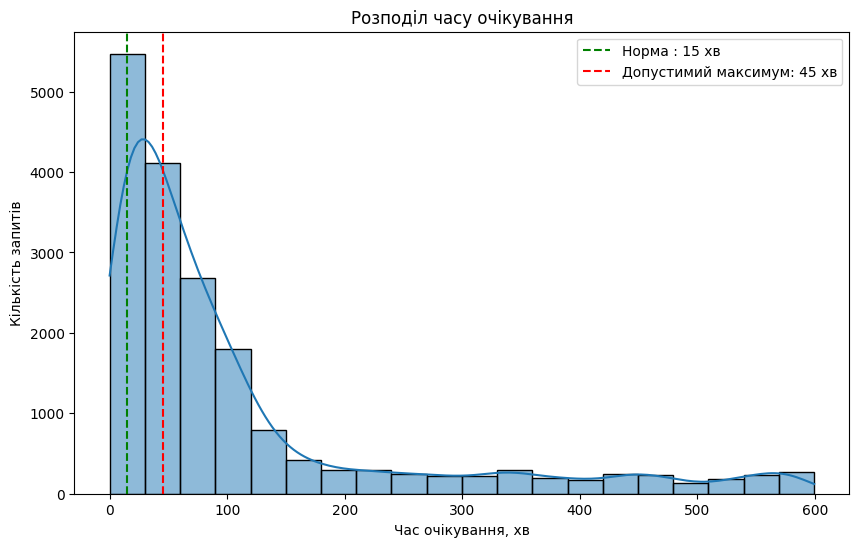

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(df_filtered['start_delay'], bins=20, kde=True)
plt.axvline(15, color='green', linestyle='--', label='Норма : 15 хв')
plt.axvline(45, color='red', linestyle='--', label='Допустимий максимум: 45 хв')
plt.title("Розподіл часу очікування")
plt.xlabel("Час очікування, хв")
plt.ylabel("Кількість запитів")
plt.legend();

In [14]:
total_requests = len(df)
within_15 = (df['start_delay'] <= 15).sum() / total_requests * 100
within_45 = (df['start_delay'] <= 45).sum() / total_requests * 100
over_45 = (df['start_delay'] > 45).sum() / total_requests * 100

In [15]:
print(f"Відсоток заявок, прийнятих в роботу до 15 хв: {within_15:.2f}%")
print(f"Відсоток заявок, що були прийняті в роботу з очікуванням понад 45 хвилин: {over_45:.2f}%")
print(f"Відсоток заявок, що були прийняті в роботу з очікуванням менше 45 хвилин: {within_45:.2f}%")

Відсоток заявок, прийнятих в роботу до 15 хв: 8.06%
Відсоток заявок, що були прийняті в роботу з очікуванням понад 45 хвилин: 78.34%
Відсоток заявок, що були прийняті в роботу з очікуванням менше 45 хвилин: 21.66%


### Висновок з графіка розподілу часу очікування (до 600 хв):

Пік заявок припадає на перші 10–30 хв, але більшість все ще перевищують ліміт у 15 хв (зелена лінія).

78.34% заявок також перетинає межу 45 хв (червона лінія), що вважається вже неприйнятним рівнем.

Розподіл асиметричний: багато заявок накопичуються в першій годині роботи відділу, бо працівники првцюють з 7:00 до 22:00(це описано нижче у розділі "Часові піки навантаження"), а далі йде “довгий хвіст” — частина заявок чекає навіть до 10 годин.

**Рекомендації:**

Зменшити “хвіст” затримок до 45+ хвилин:

Більшість проблемної зони — саме між 45–600 хв.

Потрібно або краще балансувати чергу між агентами, або збільшити кількість змін у пікові періоди.

Зосередитися на перших 30 хв:
* Якщо агент бере звернення в цей інтервал — воно майже завжди обробляється вчасно.
* Варто пріоритезувати найновіші запити або автоматизувати сортування по часу надходження.

Оптимальний час є 15–45 хв:

Саме тут можна «врятувати» багато звернень, які ще не стали критично запізнілими, але вже вийшли за норму.


## Порівняння команд

- Порівнюємо Retail vs Wholesale.
- Аналізуємо ефективність агентів.


In [16]:
df.groupby('team')['start_delay'].mean()

,start_delay
team,
retail,607.786440
wholesale,3677.494648


Час до початку обробки (start_delay)

**Retail:** ~608 хвилин (≈10 годин)
**Wholesale:** ~3677 хвилин (≈61 година)


**Пояснення:**
Цей показник ілюструє, скільки часу проходить з моменту надходження запиту до того, як агент починає його обробку.
Результати свідчать про критично довгі затримки, особливо у гуртової команди. 61 година в середньому — це в 244 рази довше за очікування менеджменту (15 хв).

**Висновок:**
Головна проблема — як довго заявка чекає у черзі перед тим, як хтось візьме його в роботу.

In [17]:
df.groupby('team')['finish_delay'].mean()

,finish_delay
team,
retail,1.977244
wholesale,2.415659


Час обробки запиту (finish_delay)

**Retail:** ~1.98 хв
**Wholesale:** ~2.42 хв

**Пояснення:**
Це час від початку до завершення обробки. Обидва значення менші за допустимі 5 хвилин, тож сам процес обробки відбувається оперативно.

**Висновок:**
Агенти працюють швидко після того, як взяли запит. Швидкість обробки хороша, проблема — в доступності агентів.


In [18]:
df.groupby('team')['id_request'].count()

,id_request
team,
retail,14025
wholesale,21592


Кількість запитів (id_request)

**Retail:** 14 025
**Wholesale:** 21 592

**Пояснення:**
Wholesale обробляє на 50% більше запитів. Це свідчить про нерівномірне навантаження між командами.

**Висновок:**
Wholesale перевантажена, тому запити обробляються із суттєвими затримками. Це також пояснює нижчу ефективність старту обробки.

### Історична дінаміка за весь період по командам.

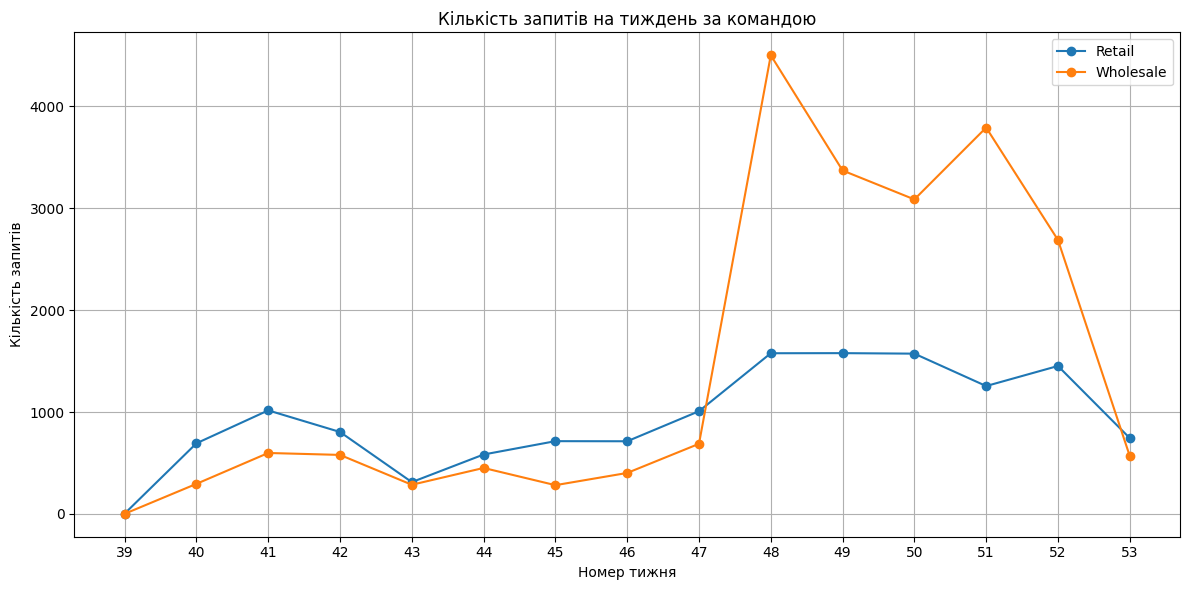

In [19]:
df['request_time'] = pd.to_datetime(df['request_time'])

df['week_number'] = df['request_time'].dt.isocalendar().week

weekly_counts = df.groupby(['week_number', 'team'])['id_request'].count().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
plt.plot(weekly_counts.index, weekly_counts['retail'], label='Retail', marker='o')
plt.plot(weekly_counts.index, weekly_counts['wholesale'], label='Wholesale', marker='o')

plt.xlabel('Номер тижня')
plt.ylabel('Кількість запитів')
plt.title('Кількість запитів на тиждень за командою')
plt.legend()
plt.grid(True)
plt.xticks(weekly_counts.index)
plt.tight_layout()

**Висновок:**

Починаючи з 47-го тижня, видно різке зростання звернень, особливо в команді **Wholesale** (помаранчева лінія).
У 48-му тижні кількість запитів у Wholesale команді досягає піку — понад 4000 на тиждень, що в кілька разів більше за попередні тижні.
**Retail** (синя лінія) також демонструє помірне зростання, але воно стабільніше і не таке стрімке.
Wholesale має сезонне навантаження, яке різко збільшується в передсвятковий період (вірогідно, Black Friday, кінець листопада – грудень. Це треба дослідити, щоб стверджувати).

**Рекомендації:**

1. Заздалегідь готуватись до пікового навантаження (тижні 47–51):
* У разі виявлення, що цей тренд спостерігався і в попередні
роки:

2. Розробити сезонний план масштабування: залучати додаткових тимчасових агентів, формувати розширені зміни.
Починати підготовку мінімум за 2 тижні до очікуваного піку — якщо це історичне зростання попиту.

3. Автоматичне виявлення аномалій у навантаженні:

* У разі різкого зростання кількості звернень система має сповіщати менеджмент для оперативного реагування.
Перерозподіл агентів між командами у пікові періоди:

* Якщо команда Retail має менше навантаження, частину агентів можна тимчасово залучити до обробки запитів Wholesale.

* Проте важливо враховувати, що роздрібні та гуртові продажі мають різну специфіку.

* Агенти з Retail можуть не володіти достатньою компетенцією для вирішення всіх типів звернень.

Тому варто:
  * або проводити перехресне навчання;
  * або обмежено довчити агентів на певну категорію заявок, які можна безпечно передати їм для обробки.


## Часові піки навантаження

- Визначаємо найнавантаженіші години та дні тижня.
- Аналізуємо динаміку запитів у часі.


In [20]:
df['request_time'].max()-df['request_time'].min()

Timedelta('98 days 15:10:01')

в нас дані майже за 99 днів

In [21]:
df['hour_start_time'] = df['start_time'].dt.hour
df['day_of_week_start_time'] = df['start_time'].dt.dayofweek

In [22]:
df['hour_start_time'].value_counts().sort_index()

,count
hour_start_time,
0,7
6,3
7,3489
8,2967
9,3443
10,2938
11,3403
12,2639
13,2929


Служба підтримки працює з 7:00 до 22:00

In [23]:
df['day_of_week_start_time'].value_counts().sort_index()

,count
day_of_week_start_time,
0,4053
1,4791
2,5090
3,6122
4,5450
5,4823
6,5288


Служба підтримки працює без вихідних.

In [24]:
print("Кількість усіх запитів:", len(df))
print("Середній час очікування (хв):", round(df['start_delay'].mean(), 2))
print("Медіанний час очікування (хв):", round(df['start_delay'].median(), 2))

Кількість усіх запитів: 35617
Середній час очікування (хв): 2468.73
Медіанний час очікування (хв): 497.62


In [25]:
df['hour'] = df['request_time'].dt.hour
df['day_of_week'] = df['request_time'].dt.dayofweek

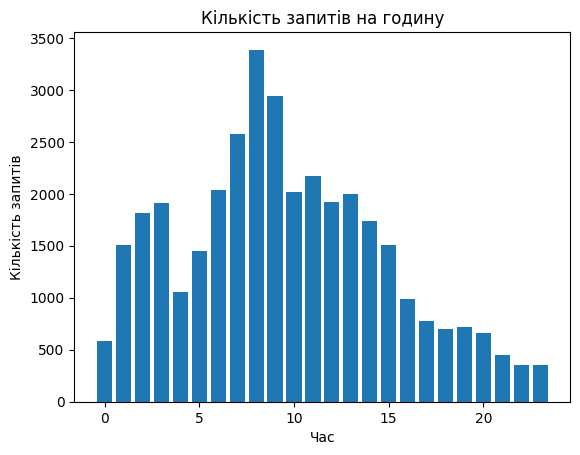

In [26]:
plt.bar(df['hour'].value_counts().index, df['hour'].value_counts())
plt.xlabel('Час')
plt.ylabel('Кількість запитів')
plt.title('Кількість запитів на годину');

Найбільше звернень надходить:

**між 6:00 та 13:00**, з піком о 8:00 ранку (понад 3500 звернень).

**Після 17:00** — помітне зниження активності.

Вночі (**0:00–5:00**) кількість звернень невелика, але вони все одно надходять — по 500–1500 на годину.
Це свідчить, що навіть у "непопулярні" години клієнти звертаються по допомогу

**Рекомендація:**

Розширити графік роботи агентів на ранній ранок і ніч.

Додати нічне покриття (0:00–6:00), навіть мінімальне — 1–2 агенти можуть обробити запити, що накопичуються в цей час.
Змістити початок зміни на 6:00, щоб встигати обробляти ранковий пік (8:00).
Це дозволить:

Скоротити черги з ночі до ранку.
Значно зменшити середній час очікування.
Покращити задоволеність клієнтів у критичні години.

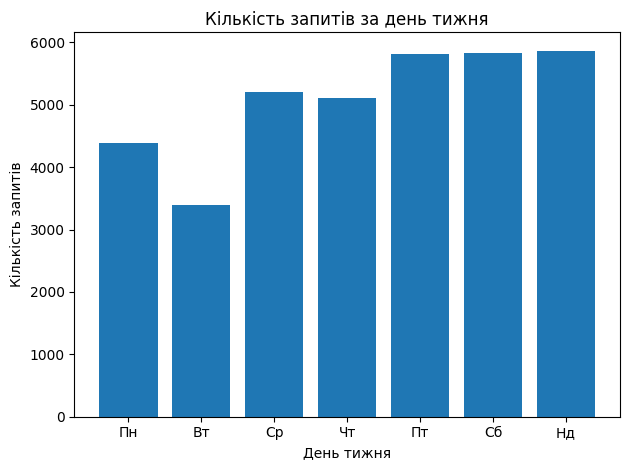

In [27]:
days_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Нд']

# Побудова графіка з оновленими підписами осі X
plt.bar(df['day_of_week'].value_counts().sort_index().index,
        df['day_of_week'].value_counts().sort_index())

plt.xlabel('День тижня')
plt.ylabel('Кількість запитів')
plt.title('Кількість запитів за день тижня')
plt.xticks(ticks=range(7), labels=days_labels)  # <- підписи днів
plt.tight_layout()

**Висновок:**

Найбільше заявок надходить у п’ятницю та суботу та неділю — понад 5800 запитів щодня.
Найменше заявок — у вівторок та понеділок.
Але навіть у "найспокійніші" дні обсяг перевищує 3500–4500 заявок, тобто стабільно високий.
Це свідчить, що навантаження значне протягом усього тижня, з піками наприкінці робочого тижня і вихідними.

**Рекомендація:**

Підсилити команду в дні пікового навантаження:
* З середи до неділі — критичні дні з найбільшим обсягом заявок.
В ці дні варто планувати більше агентів у зміну, особливо у ранкові години, коли вже починається наплив.
* Оптимізувати ресурси у “спокійніші” дні (понеділок–вівторок):
Тут можливе часткове скорочення змін або ротація, щоб збалансувати навантаження по тижню без втрат у якості.

Аналіз змін у графіку:
Якщо служба працює 7 днів на тиждень, доцільно запровадити ротаційний графік з компенсацією навантаження — наприклад, чергування суботніх і недільних змін між працівниками.



## Ефективність агентів

Найкращі та найповільніші агенти за середнім часом до відповіді:


In [28]:
agent_perf = df.groupby('moderator')['start_delay'].agg(['count', 'mean'])
agent_perf_sorted = agent_perf.sort_values('mean')
agent_perf_sorted.head(10), agent_perf_sorted.tail(10)

(           count        mean
 moderator                   
 129            1    0.033333
 138            1    0.133333
 134            8    1.106250
 171            1    2.850000
 110            1    7.133333
 114           60   73.075000
 150           16  116.510417
 167          536  268.814055
 161          181  270.862523
 178          630  387.208757,
            count         mean
 moderator                    
 125         1146  3620.503883
 102         1321  3714.671625
 123         1452  3762.907828
 170         1686  3883.557661
 188         3746  4058.972153
 187         1193  4372.228444
 112         1717  4382.390992
 180         1349  4579.584470
 181         1625  4692.149733
 126            2  5996.450000)

### Ефективність агентів за середнім часом до початку обробки (start_delay)

**ТОП-агенти (найшвидші):**

* Агенти з ID 129, 138, 134, 171, 110 мають середній час відповіді < 10 хвилин.

* Проте вони обробили лише 1–8 заявок, тож їхній результат не є статистично надійним.

* Першим ефективним і активним агентом є модератор 167, який опрацював 536 заявок із середнім часом до відповіді 268 хв (~4.5 години).
* Агент 161 (270 хв) і 178 (387 хв) також мають кращі за середні результати та достатній обсяг оброблених заявок.

**Найповільніші агенти:**

* Агенти 125, 102, 123, 170, 188, 112, 180, 165 мають дуже великі середні
затримки — від ~3600 до ~4600 хвилин (тобто 2.5–3.2 доби!).
* При цьому вони обробили 1300–3700+ запитів, тож їхній низький результат має суттєвий вплив на загальну швидкість підтримки.
* Найповільніший — агент 165 (4629 хвилин середньо, понад 1600 запитів).

**Висновок:**

* Існує велика різниця у продуктивності між агентами.
* Частина агентів постійно відповідає із затримками в декілька діб, що вкрай негативно впливає.
* Найефективніші агенти обробляють менше заявок, а найбільше навантаження лежить на повільних.

**Рекомендації:**

Перерозподілити навантаження:
1. Передати частину запитів від найповільніших агентів (125, 165, 112, 180) до
тих, хто демонструє кращі результати.
2. Провести індивідуальний аудит агентів із великими затримками:
З'ясувати причини (перевантаження, відсутність інструментів, слабка мотивація тощо).
3. Навчання або автоматизація:
Запровадити навчальні заходи для відстаючих агентів або розглянути можливість автоматичного призначення заявки на швидших операторів.

In [29]:
df.groupby('team')['start_delay'].describe().T

team,retail,wholesale
count,14025.000000,21592.000000
mean,607.786440,3677.494648
std,5000.929269,5018.511796
min,0.016667,0.033333
25%,22.283333,899.325000
50%,48.383333,3749.766667
75%,91.500000,5183.825000
max,98641.933333,117132.116667


Загальний період (всі тижні):

**Retail:**

Середній час: 607 хв (~10 год)

Медіана: 48.8 хв

**Wholesale:**

Середній час: 3677 хв (~61 год)

Медіана: 3749 хв (~2.6 днів)

In [30]:
df_weeks_39_47 = df[(df['week_number'] >= 39) & (df['week_number'] <= 47)]

In [31]:
df_weeks_39_47.groupby('team')['start_delay'].describe().T

team,retail,wholesale
count,5846.000000,3582.000000
mean,1274.144520,2186.609683
std,7605.744011,11289.674053
min,0.016667,0.033333
25%,16.725000,37.112500
50%,41.841667,106.391667
75%,89.087500,298.604167
max,98641.933333,117132.116667


Тижні 39–47 (до пікового навантаження):

**Retail:**

Середній час: 1274 хв (~21 год) — більш вдвічі порівняно з усім періодом аналізу!

Медіана: 41.8 хв

**Wholesale:**

Середній час: 2186 хв (~36 год)

Медіана: 106 хв (~1.7 год)

### рейтинг агентів по кількості прийнятих успішно заявок.

In [32]:
agent_total = df.groupby('moderator')['id_request'].count()
agent_success = df[df['start_delay'] <= 15].groupby('moderator')['id_request'].count()
agent_stats = pd.DataFrame({
    "total_requests": agent_total,
    "successful_requests": agent_success
}).fillna(0)

top_success = agent_stats["successful_requests"].sort_values(ascending=False).head(30)


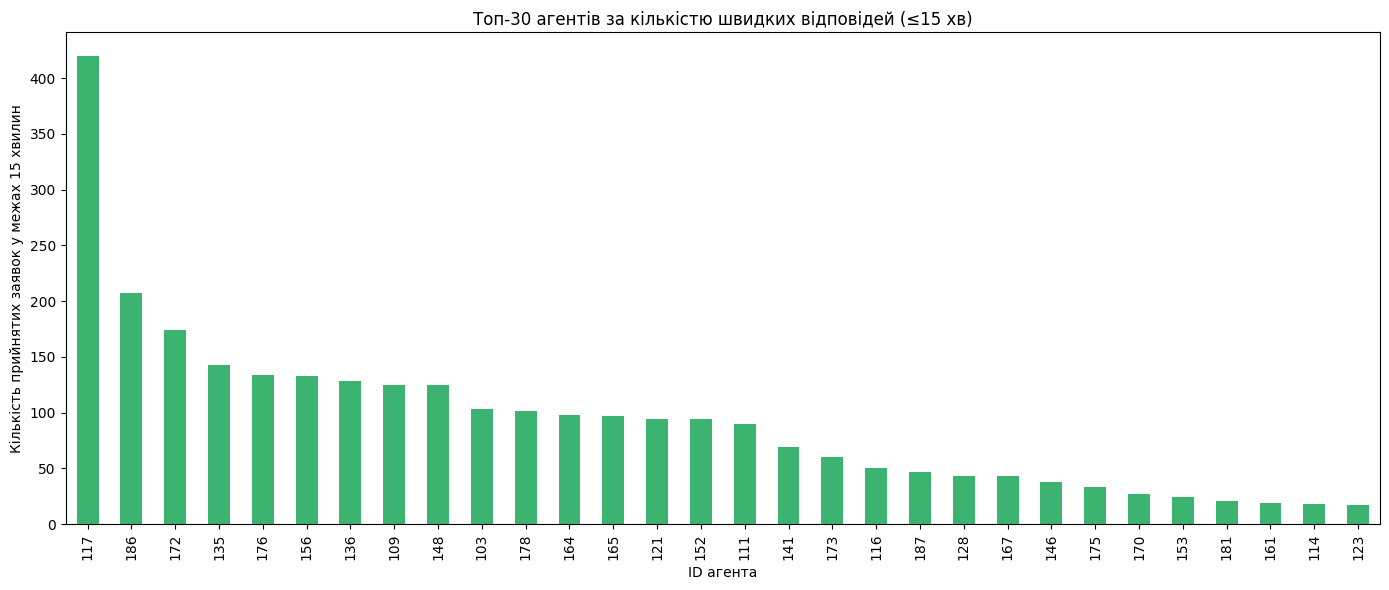

In [36]:
plt.figure(figsize=(14, 6))
top_success.plot(kind="bar", color="mediumseagreen")
plt.title("Топ-30 агентів за кількістю швидких відповідей (≤15 хв)")
plt.ylabel("Кількість прийнятих заявок у межах 15 хвилин")
plt.xlabel("ID агента")
plt.xticks(rotation=90)
plt.tight_layout()

**Висновок:**

**Агент 117** значно випереджає всіх — **понад 400** успішних відповідей у межах 15 хвилин.

Наступні ефективні агенти — **186, 172, 135, 176** — мають по 150–220 швидких відповідей.

Далі кількість швидких обробок поступово знижується.

Агентів з правого боку графіка — попри те, що увійшли в топ-30 — мають менше ніж 50 успішних обробок, отже їхній внесок значно нижчий.

У команді є потужне ядро ефективних агентів, які демонструють стабільну відповідність SLA.
Агент 117 — приклад високої швидкості реагування, можливо, має хорошу організацію черги або працює в менш завантажені години.
Інші агенти теж мають потенціал, але або не мають умов для швидкої відповіді, або менш активні.

**Рекомендації:**

Вивчити підхід топ-агентів (особливо #117):

Як їм вдається обробляти так багато звернень вчасно?

Можна масштабувати їхні практики (розподіл, зміни, навички) на інші команди.

Розподіляти більше запитів на агентів із найвищою швидкістю:

Автоматичне пріоритезування або зміна черги допоможе підняти швидкість відповіді.

Мотивувати менш активних агентів або агентів з нижчими показниками, щлб вони  покращювали результат:

Наприклад через бонуси за швидку відповідь тощо.


## Загальний висновок та відповіді на ключові питання

---

### Загальний висновок:
Служба підтримки **не відповідає** очікуванням менеджменту щодо швидкості відповіді:

- Очікування: **відповідь ≤ 15 хв**, допустимий максимум — **45 хв**.
- Реальність:
  - **Retail** — середній час відповіді: ~ 608 хв (~10 год).
  - **Wholesale** — ~ 3677 хв (~61 год).
- **>78%** запитів обробляються із затримкою понад 45 хв.
- Головна проблема — **затримка до взяття в роботу**, а не тривалість обробки (2–3 хв).

---

### Відповіді на питання

#### 1. Наскільки служба підтримки відповідає очікуванням менеджменту? Як вона працює зараз?

**Не відповідає.** Затримки в десятки годин, особливо в команді Wholesale. В періоди пікового навантаження ситуація ще гірша.

---

#### 2. На яких агентів варто звернути увагу задля підвищення якості обслуговування?

- **Найефективніші агенти:** `117`, `186`, `172`, `135` — найбільше швидких відповідей ≤ 15 хв.
- **Найповільніші агенти:** `125`, `165`, `188`, `112`, `123` — середня затримка 2–3 доби.
- Варто провести аудит завантаження та підтримати слабші сторони.

---

#### 3. Чи варто збільшити команду підтримки і наскільки?

**Так.** У пікові тижні обсяг заявок зростає в 2–4 рази.

- Рекомендується **збільшити штат на 30–50% у сезон**.
- Впровадити **гнучку модель**: постійна команда + тимчасові агенти.

---

#### 4. Як варто змінити графік служби підтримки?

- Починати зміни з **6:00** (замість 7:00) — більшість заявок надходить раніше.
- Впровадити **чергування з 22:00 до 6:00** — для нічного покриття.
- Підсилити ранкові та обідні зміни (**8:00–13:00**).
- Посилити команди у **четвер–суботу** — найнавантаженіші дні.

---

#### 5. Чи є вигода від об'єднання команд?

**Так.**

- Retail — ефективніший, Wholesale — перевантажений.
- Об’єднання дозволить **краще балансувати ресурси**.
- Альтернатива — **перехресне навчання** агентів для взаємопідтримки.

---

### Резюме:

- Очікуванням менеджменту щодо швидкості відповіді не виконується, особливо в Wholesale.
- Проблеми концентруються вночі, у пікові тижні, та на перевантажених агентів.
- Рекомендується:
  - Збільшити команду.
  - Оптимізувати розклад.
  - Перерозподілити запити.
  - Вивчити практики ефективних агентів.
